In [1]:
import gurobipy as gb
from gurobipy import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

## Parameters

In [2]:
# Emergency call box coordinates
df_candidate = pd.read_csv("exisiting_and_candidate_callbox_coords.csv")
candidate_x = df_candidate['x'].to_list()
candidate_y = df_candidate['y'].to_list()
J = []  # Set of call box coordinates

for i in range(len(df_candidate)):
  J.append((candidate_x[i],candidate_y[i]))

In [3]:
# Emergency phone demand point coordinates
df_demand = pd.read_csv("demand_point_coords.csv")
demand_x = df_demand['x'].to_list()
demand_y = df_demand['y'].to_list()
I = [] # Set of demand point coordinates

for i in range(len(df_demand)):
  I.append((demand_x[i],demand_y[i]))

In [4]:
# Current state of existing call boxes
df_current = pd.read_csv("existing_callbox_current_state.csv")
print(f"Loaded current state for {len(df_current)} existing locations")

# Dictinaries
phone_names = {
    0: "Type 1 with Panoramic Camera",
    1: "Type 1 with Fixed Camera",
    2: "Type 2",
    3: "Type 3",
    4: "Old Phone"
}

condition_names = {0: "New", 1: "Good", 2: "Rusted", 3: "Broken"}

Loaded current state for 23 existing locations


In [5]:
demand_num = len(I)
location_num = len(J)
k_num = 5  # Number of phone names
period_num = 2 # t = 0 (current or initial), t = 1 (final)

# Euclidian distance matrix calculation
I_arr = np.array(I)
J_arr = np.array(J)
dist_matrix = np.sqrt(((I_arr[:, None, :] - J_arr[None, :, :])**2).sum(axis=2))

R = [150, 100, 60, 45, 20]  # Coverage radius for each phone type
C = [19_500, 10_500, 3500, 2000, 0]  # Cost (k=4 has 0 cost as it's keeping old)
lmbda = 1000  # Penalty multiplier for not replacing
alpha = 0.65  # % of demand points to cover; any higher would render the model infeasible
W = df_demand['weight'].to_list()  # Weights for each demand location

H_old = df_current['State H'].to_list()
H = H_old + [0] * (location_num - len(H_old))  # Current state of call boxes
initial_phone_types = df_current['Phone K'].to_list() 

# Create model
model = gb.Model('Emergency Phone Box Optimization')

Set parameter Username
Set parameter LicenseID to value 2704720
Academic license - for non-commercial use only - expires 2026-09-08


## Decision Variables

In [6]:
# Decision variables
X = model.addVars(period_num, location_num, k_num, vtype=GRB.BINARY)  # 1 if location j has a phone of type k in period t; 0 otherwise
A = model.addVars(demand_num, location_num, k_num, vtype=GRB.BINARY)  # 1 if demand point i is covered by a phone of type k at location j in period 1; 0 otherwise
Y = model.addVars(demand_num, vtype=GRB.BINARY)  # 1 if demand point i is covered by at least one phone in period 1; 0 otherwise

## Objective Function

In [7]:
# Cost of installing NEW phones (k=0,1,2,3) at ANY location in period 1
# For existing locations (j < 23): only charge if replacing (k != existing type)
installation_cost_existing = gb.quicksum(
    X[1, j, k] * C[k]
    for j in range(23)
    for k in range(4)
    if k != initial_phone_types[j]
)

# For new locations (j >= 23): always charge equipment cost
installation_cost_new = gb.quicksum(
    X[1, j, k] * C[k]
    for j in range(23, location_num)
    for k in range(4)
)

# Penalty for KEEPING old phones at EXISTING locations
penalty_keep_old = gb.quicksum(
    X[1, j, 4] * H[j] * lmbda
    for j in range(23)
)

# Set objective
model.setObjective(installation_cost_existing + installation_cost_new + penalty_keep_old, GRB.MINIMIZE)

model.update()

## Constraints

In [8]:
# 1. INITIAL STATE CONSTRAINTS
# Existing locations (0-22) have old phones initially
for j in range(len(initial_phone_types)):
    k_existing = initial_phone_types[j]
    
    # This location has phone type k_existing
    model.addConstr(X[0, j, k_existing] == 1, name=f"init_phone_{j}_{k_existing}")
    
    # All other phone types are 0 at this location
    for k in range(k_num):
        if k != k_existing:
            model.addConstr(X[0, j, k] == 0, name=f"no_phone_{j}_{k}")

# New locations (23-122) have nothing initially
for j in range(23, location_num):
    for k in range(k_num):
        model.addConstr(X[0, j, k] == 0, name=f"empty_initial_{j}_{k}")

# 2. FINAL STATE CONSTRAINTS
# At most one phone type per location in period 1
model.addConstrs(
    (gb.quicksum(X[1, j, k] for k in range(k_num)) <= 1 
    for j in range(location_num)),
    name="one_type_p1"
)

# New locations (23-122) cannot have old phones in period 1
for j in range(23, location_num):
    model.addConstr(X[1, j, 4] == 0, name=f"no_old_new_loc_{j}")

# 3. COVERAGE CONSTRAINTS
# A demand point can only be assigned to a phone that exists in period 1
model.addConstrs(
    (A[i, j, k] <= X[1, j, k]
    for i in range(demand_num)
    for j in range(location_num)
    for k in range(k_num)),
    name="assign_only_if_exists_p1"
)

# Each demand point is covered if assigned to at least one phone
model.addConstrs(
    (gb.quicksum(A[i, j, k] for j in range(location_num) for k in range(k_num)) >= Y[i] 
    for i in range(demand_num)),
    name="covered_if_assigned"
)

# Coverage radius constraints
for i in range(demand_num):
    for j in range(location_num):
        for k in range(k_num):
            if dist_matrix[i, j] > R[k]:
                model.addConstr(A[i, j, k] == 0, name=f"radius_{i}_{j}_{k}")

# Minimum coverage requirement
model.addConstr(
    (gb.quicksum(W[i] * Y[i] for i in range(demand_num)) >= 
    alpha * gb.quicksum(W[i] for i in range(demand_num))),
    name="min_weighted_coverage"
)

# 4. NO REMOVAL - existing locations must always have a phone
for j in range(23):
    model.addConstr(
        (gb.quicksum(X[1, j, k] for k in range(k_num)) == 1),
        name=f"no_removal_existing_{j}"
    )

# 5. NO DOWNGRADE - cannot replace with worse phone type
# Phone quality hierarchy: 0 (best) > 1 > 2 > 3 > 4 (worst)
for j in range(23):
    k_existing = initial_phone_types[j]
    
    # Cannot install phones with higher k value (worse quality)
    if k_existing < 4:  # If it's not an old phone
        for k_worse in range(k_existing + 1, k_num):
            model.addConstr(
                X[1, j, k_worse] == 0, 
                name=f"no_downgrade_{j}_to_{k_worse}"
            )

## Optimal Solution

In [9]:
# Optimize
model.optimize()

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 12th Gen Intel(R) Core(TM) i5-12500H, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 121004 rows, 61598 columns and 242225 nonzeros
Model fingerprint: 0x88e34bea
Variable types: 0 continuous, 61598 integer (61598 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+03, 2e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+01]
Presolve removed 120373 rows and 60774 columns
Presolve time: 0.04s
Presolved: 631 rows, 824 columns, 1898 nonzeros
Variable types: 0 continuous, 824 integer (824 binary)
Found heuristic solution: objective 1599500.0000
Found heuristic solution: objective 643500.00000
Performing another presolve...
Presolve removed 576 rows and 697 columns
Presolve time: 0.01s
Found heuristic solution: objective 341000.00000

Root relaxation: objectiv

In [10]:
# Print results
if model.status == GRB.OPTIMAL:
    # Detailed decisions for existing locations
    print("DECISIONS FOR EXISTING LOCATIONS:")
   
    replaced = []
    kept = []
    
    for j in range(len(initial_phone_types)):
        k_existing = initial_phone_types[j]
        condition = H_old[j]
        
        # Check what happened at this location
        kept_existing = X[1, j, k_existing].x > 0.5
        
        if kept_existing:
            kept.append(j)
            print(f"Location {j:2d}: KEEP {phone_names[k_existing]:<20} (Condition: {condition_names[condition]})")
        else:
            # Find what it was replaced with
            for k_new in range(k_num):
                if k_new != k_existing and X[1, j, k_new].x > 0.5:
                    replaced.append((j, k_existing, k_new))
                    print(f"Location {j:2d}: REPLACE {phone_names[k_existing]:<20} ({condition_names[condition]}) -> {phone_names[k_new]} (${C[k_new]:,})")
                    break
    
    # New installations
    print(f"\nNEW INSTALLATIONS:")
    new_installs = []
    for j in range(len(initial_phone_types), location_num):
        for k in range(4):  # Only new types can be installed
            if X[1, j, k].x > 0.5:
                new_installs.append((j, k))
                print(f"Location {j:2d}: Install {phone_names[k]:<20} (${C[k]:,})")
    
    # Summary
    print("\nSUMMARY:")
    print(f"  Existing locations kept as-is: {len(kept)}")
    print(f"  Existing locations replaced: {len(replaced)}")
    print(f"  New installations: {len(new_installs)}")
    print(f"  Total phones in period 1: {sum(X[1, j, k].x for j in range(location_num) for k in range(k_num)):.0f}")
    
    # Coverage statistics
    covered_count = sum(Y[i].x for i in range(demand_num))
    weighted_covered = sum(W[i] * Y[i].x for i in range(demand_num))
    
    print(f"\nCOVERAGE ACHIEVED:")
    print(f"  Demand points covered: {covered_count:.0f}/{demand_num} ({100*covered_count/demand_num:.1f}%)")
    print(f"  Weighted coverage: {weighted_covered:.1f}/{sum(W):.1f} ({100*weighted_covered/sum(W):.1f}%)")
    
    # Only sum costs for replacements (k != initial) or new locations
    inst_cost_existing = sum(
        X[1, j, k].x * C[k]
        for j in range(23)
        for k in range(4)
        if k != initial_phone_types[j]
    )
    inst_cost_new = sum(
        X[1, j, k].x * C[k]
        for j in range(23, location_num)
        for k in range(4)
    )
    inst_cost = inst_cost_existing + inst_cost_new
    
    penalty_cost = model.objVal - inst_cost
    print(f"\nCOST BREAKDOWN:")
    print(f"  Installation costs: ${inst_cost:,.2f}")
    print(f"  Penalty costs: ${penalty_cost:,.2f}")
    print(f"  Total: ${model.objVal:,.2f}")

DECISIONS FOR EXISTING LOCATIONS:
Location  0: KEEP Old Phone            (Condition: Rusted)
Location  1: REPLACE Old Phone            (Rusted) -> Type 1 with Panoramic Camera ($19,500)
Location  2: REPLACE Old Phone            (Good) -> Type 1 with Panoramic Camera ($19,500)
Location  3: KEEP Old Phone            (Condition: Good)
Location  4: REPLACE Old Phone            (Rusted) -> Type 1 with Panoramic Camera ($19,500)
Location  5: KEEP Old Phone            (Condition: Rusted)
Location  6: REPLACE Old Phone            (Rusted) -> Type 3 ($2,000)
Location  7: KEEP Old Phone            (Condition: Good)
Location  8: KEEP Old Phone            (Condition: Rusted)
Location  9: KEEP Old Phone            (Condition: Good)
Location 10: KEEP Old Phone            (Condition: Good)
Location 11: KEEP Type 1 with Panoramic Camera (Condition: New)
Location 12: KEEP Type 1 with Panoramic Camera (Condition: New)
Location 13: KEEP Type 3               (Condition: New)
Location 14: KEEP Type 1 with 

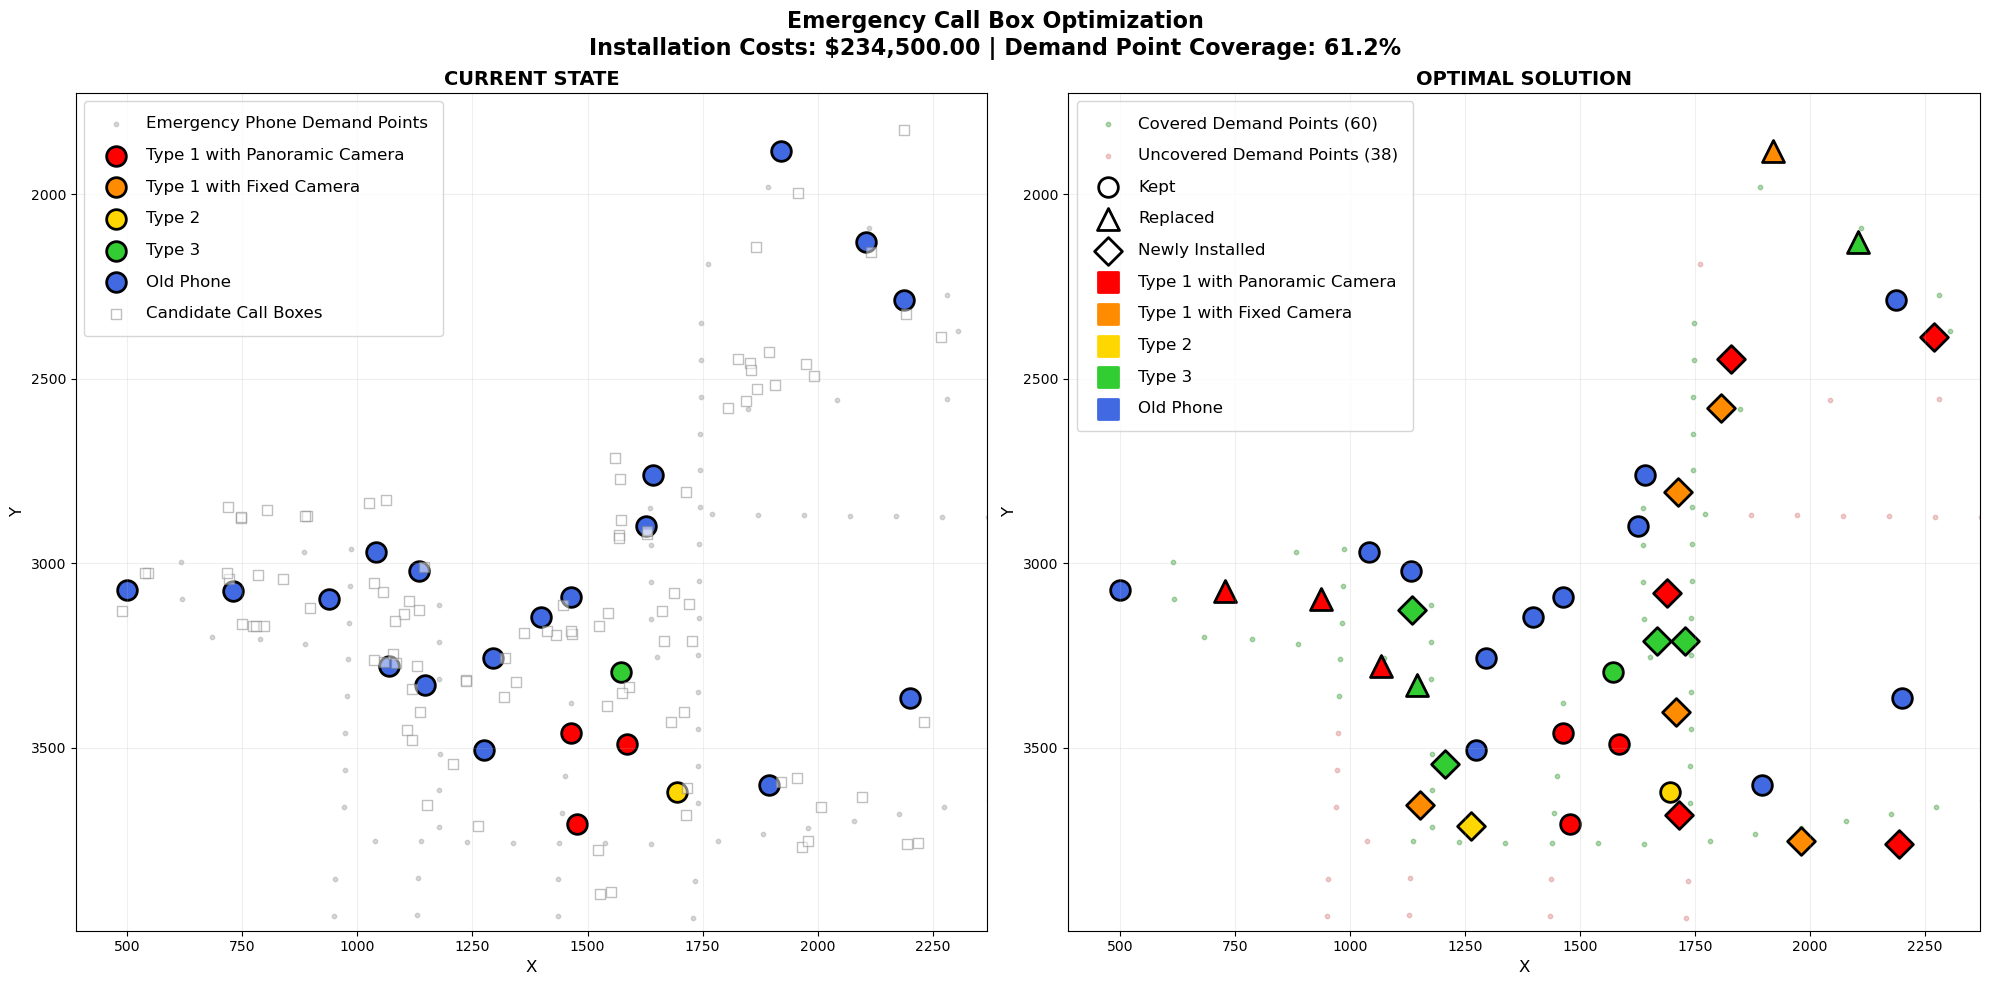

In [11]:
# Visualization
if model.status == GRB.OPTIMAL:
    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # Color scheme for phone types
    phone_colors = {
        0: '#FF0000',  # Red - Type 1 with Panoramic Camera
        1: '#FF8C00',  # Orange - Type 1 with Fixed Camera
        2: '#FFD700',  # Gold - Type 2
        3: '#32CD32',  # Green - Type 3
        4: '#4169E1'   # Blue - Old Phone
    }
    
    phone_labels = {
        0: 'Type 1 with Panoramic Camera',
        1: 'Type 1 with Fixed Camera',
        2: 'Type 2',
        3: 'Type 3',
        4: 'Old Phone'
    }
    
    # CURRENT STATE (PERIOD 0)
    # Plot demand points
    ax1.scatter([i[0] for i in I], [i[1] for i in I], 
                c='gray', s=10, alpha=0.3, label='Emergency Phone Demand Points')
    
    # Plot existing phones (locations 0-22)
    for j in range(23):
        k_type = initial_phone_types[j]
        ax1.scatter(J[j][0], J[j][1], 
                   c=phone_colors[k_type], 
                   s=200, marker='o', 
                   edgecolor='black', linewidth=2)
        
    # Add legend for marker meanings
    for i in range(k_num):
        ax1.scatter([], [], c=phone_colors[i], s=200, marker='o', edgecolor='black', linewidth=2, label=phone_labels[i])

    # Plot candidate locations (23+)
    candidate_x = [J[j][0] for j in range(23, location_num)]
    candidate_y = [J[j][1] for j in range(23, location_num)]
    ax1.scatter(candidate_x, candidate_y, 
                c='white', s=50, marker='s', 
                edgecolor='gray', linewidth=1, alpha=0.5,
                label='Candidate Call Boxes')
    
    ax1.set_title('CURRENT STATE', fontsize=14, fontweight='bold')
    ax1.set_xlabel('X', fontsize=12)
    ax1.set_ylabel('Y', fontsize=12)
    ax1.legend(loc='best', fontsize=12, labelspacing=1, borderpad=0.9)
    ax1.grid(True, alpha=0.2)

    
    # OPTIMAL SOLUTION (PERIOD 1)
    # Plot demand points colored by coverage
    covered_demand_x = [I[i][0] for i in range(demand_num) if Y[i].x > 0.5]
    covered_demand_y = [I[i][1] for i in range(demand_num) if Y[i].x > 0.5]
    uncovered_demand_x = [I[i][0] for i in range(demand_num) if Y[i].x <= 0.5]
    uncovered_demand_y = [I[i][1] for i in range(demand_num) if Y[i].x <= 0.5]
    
    ax2.scatter(covered_demand_x, covered_demand_y, 
                c='green', s=10, alpha=0.3, label=f'Covered Demand Points ({len(covered_demand_x)})')
    ax2.scatter(uncovered_demand_x, uncovered_demand_y, 
                c='indianred', s=10, alpha=0.3, label=f'Uncovered Demand Points ({len(uncovered_demand_x)})')
    
    # Track which phone types are plotted for legend
    plotted_types = set()
    
    # Plot phones in period 1 with different markers for status
    for j in range(location_num):
        for k in range(k_num):
            if X[1,j,k].x > 0.5:
                # Determine status (replaced/kept/new)
                if j < 23:  # Existing location
                    if k == initial_phone_types[j]:
                        marker = 'o'  # Circle = Kept
                        status = 'Kept'
                        markersize = 200
                    else:
                        marker = '^'  # Triangle = Replaced/Upgraded
                        status = 'Replaced'
                        markersize = 250
                else:  # New location
                    marker = 'D'  # Diamond = Newly Installed
                    status = 'New'
                    markersize = 200
                
                ax2.scatter(J[j][0], J[j][1], 
                           c=phone_colors[k], 
                           s=markersize, marker=marker,
                           edgecolor='black', linewidth=2)
    
    # Add legend for marker meanings
    ax2.scatter([], [], c='white', s=200, marker='o', edgecolor='black', linewidth=2, label='Kept')
    ax2.scatter([], [], c='white', s=250, marker='^', edgecolor='black', linewidth=2, label='Replaced')
    ax2.scatter([], [], c='white', s=200, marker='D', edgecolor='black', linewidth=2, label='Newly Installed')
    for i in range(k_num):
        ax2.scatter([], [], c=phone_colors[i], s=200, marker='s', linewidth=2, label=phone_labels[i])
    
    ax2.set_title('OPTIMAL SOLUTION', fontsize=14, fontweight='bold')
    ax2.set_xlabel('X', fontsize=12)
    ax2.set_ylabel('Y', fontsize=12)
    ax2.legend(loc='best', fontsize=12, labelspacing=1, borderpad=0.9)
    ax2.grid(True, alpha=0.2)
    
    # Make both plots have same axis limits for easy comparison
    for ax in [ax1, ax2]:
        ax.set_xlim(min([j[0] for j in J]) - 100, max([j[0] for j in J]) + 100)
        ax.set_ylim(min([j[1] for j in J]) - 100, max([j[1] for j in J]) + 100)
        ax.invert_yaxis() 
        
    plt.suptitle(f'Emergency Call Box Optimization\nInstallation Costs: ${inst_cost:,.2f} | Demand Point Coverage: {100*covered_count/demand_num:.1f}%', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    fig.savefig("emergency_callbox_optimization.png", dpi=300, bbox_inches="tight")
    plt.show()